In [1]:
import pdb
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import warnings

%matplotlib inline
warnings.simplefilter('ignore')
sns.set(style="whitegrid")

In [2]:
data = pd.read_csv("../data/interum/top_genres.csv")

#slicing data before the 21st century
data = data[data.release_date < '2000-01-01']

In [3]:
def plot_scatter_relationship(data, x, y="Energy"):
    plt.scatter(x=data[x], y=data[y], alpha=0.1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs. {y}")

In [4]:
def plot_distributions(data, x):
    scaler = MinMaxScaler()
    sns.distplot(a=scaler.fit(np.array(data[x]).reshape(-1,1)).transform(np.array(data[x]).reshape(-1,1)), bins=500)
    plt.title(x)
    plt.show()


In [5]:
def adjusted_r_squared(r_squared, num_samples, num_regressors):
    return 1 - ((1-r_squared)*(num_samples - 1) / (num_samples - num_regressors - 1))

## Linear Regression Predicting _Energy_

subset data relevant for predicting energy: 

In [6]:
energy_reg_df = data[[
    "Danceability",
    "Energy",
    "Loudness",
    "Mode",
    "Speechness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
    "Valence",
    "Tempo",
    "Duration_ms",
    'Super_genre',
    'time_signature'
]]
energy_reg_df.head()

,Danceability,Energy,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Super_genre,time_signature
86,0.355,0.892,-5.638,0.0,0.0513,0.000013,0.0251,0.1080,0.3050,177.059,344027.0,metal,4.0
96,0.480,0.955,-5.327,1.0,0.0563,0.000006,0.7950,0.1170,0.0975,125.042,393920.0,metal,4.0
132,0.259,0.872,-5.469,0.0,0.0477,0.000308,0.5440,0.0957,0.5030,98.501,330933.0,metal,4.0
160,0.410,0.925,-6.183,0.0,0.0623,0.000004,0.6480,0.3290,0.4090,81.543,182773.0,metal,4.0
175,0.603,0.969,-6.911,0.0,0.0570,0.019100,0.4620,0.1700,0.3570,160.018,175813.0,metal,4.0


In [7]:
# numeric = energy_reg_df[[
#         "Danceability",
#     "Energy",
#     "Loudness",
#     "Speechness",
#     "Acousticness",
#     "Instrumentalness",
#     "Liveness",
#     "Valence",
#     "Tempo",
#     "Duration_ms"
# ]]
# figure = plt.figure(figsize=(10, 8))
# sns.heatmap(numeric.corr(), center =0)
# plt.savefig('Correlation.png')
# plt.show()

In [8]:
# figure = plt.figure(figsize=(10, 8))
# sns.pairplot(numeric)
# plt.title("Feature Plots")
# plt.savefig('feature_plots.png')
# plt.show()

Duration appears to benefit from a log transformation, so we add that here

## Dummy Variables

* Mode - basically major or minor
* time_signature - some integer representing the numerator in the time signature

#### Step 1
cast all categorical variables to strings so we can use pd.get_dummies()

In [9]:
energy_reg_df.Mode = energy_reg_df.Mode.astype(int)
energy_reg_df.time_signature = energy_reg_df.time_signature.astype(int)
energy_reg_df.Mode = energy_reg_df.Mode.astype(str)
energy_reg_df.time_signature = energy_reg_df.time_signature.astype(str)

#### step 2

generate dummy variables using get_dummies()

In [10]:
energy_reg_df=pd.get_dummies(energy_reg_df)
energy_reg_df.head()

,Danceability,Energy,Loudness,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,...,Super_genre_soul,Super_genre_step,Super_genre_swing,Super_genre_synth,Super_genre_techno,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
86,0.355,0.892,-5.638,0.0513,0.000013,0.0251,0.1080,0.3050,177.059,344027.0,...,0,0,0,0,0,0,0,0,1,0
96,0.480,0.955,-5.327,0.0563,0.000006,0.7950,0.1170,0.0975,125.042,393920.0,...,0,0,0,0,0,0,0,0,1,0
132,0.259,0.872,-5.469,0.0477,0.000308,0.5440,0.0957,0.5030,98.501,330933.0,...,0,0,0,0,0,0,0,0,1,0
160,0.410,0.925,-6.183,0.0623,0.000004,0.6480,0.3290,0.4090,81.543,182773.0,...,0,0,0,0,0,0,0,0,1,0
175,0.603,0.969,-6.911,0.0570,0.019100,0.4620,0.1700,0.3570,160.018,175813.0,...,0,0,0,0,0,0,0,0,1,0


## Linear Regression Model

Using energy as our target

In [12]:
# Set dependent and independent variables
y = energy_reg_df.Energy
X = energy_reg_df.drop('Energy', axis=1)
# Get dummy variables and add constant for intercept
X = sm.add_constant(X)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.7)

# fit and summarize your model
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     1205.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:46:12   Log-Likelihood:                 9470.8
No. Observations:               13773   AIC:                        -1.886e+04
Df Residuals:                   13733   BIC:                        -1.856e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5370      0.007     76.024      0.000       0.523       0.551
Danceability             -0.1985      0.008    -24.756      0.000      -0.214      -0.183
Loudness                  0.0269      0.000     99.998      0.000       0.026       0.027
Speechness                0.2824      0.014     19.880      0.000       0.255       0.310
Acousticness             -0.2873      0.004    -70.600      0.000      -0.295      -0.279
Instrumentalness          0.0783      0.004     21.326      0.000       0.071       0.086
Liveness                  0.0952      0.007     14.394      0.000       0.082       0.108
Valence                   0.1874      0.005     35.646      0.000       0.177       0.198
Tempo                     0.0003   3.83e-05      7.320      0.000       0.000       0.000
Duration_ms           -3.183e-09   8.35e-09     -0.381      0.703   -1.95e-08    1.32e-08
Mode_0                    0.2713      0.004     72.392      0.000       0.264       0.279
Mode_1                    0.2657      0.004     72.429      0.000       0.258       0.273
Super_genre_blues        -0.0119      0.007     -1.767      0.077      -0.025       0.001
Super_genre_classical     0.0099      0.010      1.023      0.306      -0.009       0.029
Super_genre_country       0.0093      0.012      0.742      0.458      -0.015       0.034
Super_genre_dance         0.1055      0.011      9.621      0.000       0.084       0.127
Super_genre_disco        -0.0122      0.015     -0.796      0.426      -0.042       0.018
Super_genre_elect         0.0615      0.012      5.067      0.000       0.038       0.085
Super_genre_folk         -0.0396      0.006     -7.164      0.000      -0.050      -0.029
Super_genre_general       0.0213      0.004      5.129      0.000       0.013       0.029
Super_genre_grunge        0.0207      0.017      1.192      0.233      -0.013       0.055
Super_genre_guitar        0.0483      0.007      6.777      0.000       0.034       0.062
Super_genre_hiphop       -0.0593      0.009     -6.828      0.000      -0.076      -0.042
Super_genre_house         0.0393      0.019      2.098      0.036       0.003       0.076
Super_genre_indie         0.0216      0.007      3.197      0.001       0.008       0.035
Super_genre_jazz         -0.0003      0.006     -0.041      0.968      -0.012       0.012
Super_genre_latin        -0.0229      0.024     -0.945      0.345      -0.070       0.025
Super_genre_metal         0.0817      0.006     14.416      0.000       0.071       0.093
Super_genre_pop           0.0253      0.005      4.932      0.000       0.015       0.035
Super_genre_punk          0.0433      0.007      6.102      0.000       0.029       0.057
Super_genre_r_and_b      -0.0759      0.037     -2.037      0.042      -0.149      -0.003
Super_genre_reggae     

In [13]:
# fit and summarize your model
model = sm.OLS(y_train,X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     845.1
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:46:12   Log-Likelihood:                 6633.6
No. Observations:                9641   AIC:                        -1.319e+04
Df Residuals:                    9601   BIC:                        -1.290e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5455      0.009     62.833      0.000       0.528       0.563
Danceability             -0.1986      0.010    -20.601      0.000      -0.217      -0.180
Loudness                  0.0272      0.000     84.346      0.000       0.027       0.028
Speechness                0.2937      0.017     17.508      0.000       0.261       0.327
Acousticness             -0.2867      0.005    -58.702      0.000      -0.296      -0.277
Instrumentalness          0.0806      0.004     18.316      0.000       0.072       0.089
Liveness                  0.0959      0.008     12.129      0.000       0.080       0.111
Valence                   0.1837      0.006     29.000      0.000       0.171       0.196
Tempo                     0.0003   4.59e-05      5.828      0.000       0.000       0.000
Duration_ms            2.253e-09   1.02e-08      0.222      0.824   -1.77e-08    2.22e-08
Mode_0                    0.2762      0.005     60.122      0.000       0.267       0.285
Mode_1                    0.2693      0.004     59.867      0.000       0.260       0.278
Super_genre_blues        -0.0129      0.008     -1.604      0.109      -0.029       0.003
Super_genre_classical     0.0119      0.011      1.046      0.296      -0.010       0.034
Super_genre_country       0.0051      0.015      0.340      0.734      -0.024       0.034
Super_genre_dance         0.1079      0.013      8.118      0.000       0.082       0.134
Super_genre_disco         0.0031      0.018      0.171      0.865      -0.033       0.039
Super_genre_elect         0.0711      0.014      5.021      0.000       0.043       0.099
Super_genre_folk         -0.0397      0.007     -6.001      0.000      -0.053      -0.027
Super_genre_general       0.0210      0.005      4.203      0.000       0.011       0.031
Super_genre_grunge       -0.0070      0.020     -0.355      0.722      -0.045       0.031
Super_genre_guitar        0.0523      0.009      6.128      0.000       0.036       0.069
Super_genre_hiphop       -0.0624      0.010     -6.106      0.000      -0.082      -0.042
Super_genre_house         0.0468      0.027      1.757      0.079      -0.005       0.099
Super_genre_indie         0.0205      0.008      2.536      0.011       0.005       0.036
Super_genre_jazz          0.0015      0.007      0.207      0.836      -0.013       0.016
Super_genre_latin        -0.0201      0.028     -0.718      0.473      -0.075       0.035
Super_genre_metal         0.0793      0.007     11.641      0.000       0.066       0.093
Super_genre_pop           0.0254      0.006      4.132      0.000       0.013       0.038
Super_genre_punk          0.0423      0.009      4.958      0.000       0.026       0.059
Super_genre_r_and_b      -0.0670      0.048     -1.394      0.163      -0.161       0.027
Super_genre_reggae     

In [14]:
# fit and summarize your model
model = sm.OLS(y_test,X_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     247.4
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:46:12   Log-Likelihood:                 1913.5
No. Observations:                2755   AIC:                            -3749.
Df Residuals:                    2716   BIC:                            -3518.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5054      0.014     36.572      0.000       0.478       0.532
Danceability             -0.1880      0.018    -10.567      0.000      -0.223      -0.153
Loudness                  0.0258      0.001     43.434      0.000       0.025       0.027
Speechness                0.2433      0.034      7.129      0.000       0.176       0.310
Acousticness             -0.2884      0.009    -32.094      0.000      -0.306      -0.271
Instrumentalness          0.0696      0.008      8.389      0.000       0.053       0.086
Liveness                  0.0997      0.015      6.560      0.000       0.070       0.130
Valence                   0.1885      0.012     16.155      0.000       0.166       0.211
Tempo                     0.0004   8.59e-05      4.338      0.000       0.000       0.001
Duration_ms           -2.095e-08   1.66e-08     -1.265      0.206   -5.34e-08    1.15e-08
Mode_0                    0.2558      0.007     34.487      0.000       0.241       0.270
Mode_1                    0.2496      0.007     34.147      0.000       0.235       0.264
Super_genre_blues         0.0021      0.015      0.140      0.889      -0.027       0.031
Super_genre_classical     0.0026      0.022      0.120      0.904      -0.040       0.046
Super_genre_country       0.0204      0.026      0.782      0.435      -0.031       0.072
Super_genre_dance         0.1137      0.022      5.085      0.000       0.070       0.158
Super_genre_disco        -0.0197      0.035     -0.566      0.572      -0.088       0.048
Super_genre_elect         0.0343      0.028      1.227      0.220      -0.020       0.089
Super_genre_folk         -0.0413      0.012     -3.518      0.000      -0.064      -0.018
Super_genre_general       0.0261      0.008      3.187      0.001       0.010       0.042
Super_genre_grunge        0.1278      0.042      3.042      0.002       0.045       0.210
Super_genre_guitar        0.0456      0.016      2.766      0.006       0.013       0.078
Super_genre_hiphop       -0.0519      0.020     -2.578      0.010      -0.091      -0.012
Super_genre_house         0.0421      0.033      1.264      0.207      -0.023       0.107
Super_genre_indie         0.0366      0.015      2.461      0.014       0.007       0.066
Super_genre_jazz          0.0126      0.014      0.921      0.357      -0.014       0.039
Super_genre_latin        -0.2366      0.083     -2.849      0.004      -0.399      -0.074
Super_genre_metal         0.0994      0.012      8.556      0.000       0.077       0.122
Super_genre_pop           0.0361      0.011      3.432      0.001       0.015       0.057
Super_genre_punk          0.0469      0.016      3.012      0.003       0.016       0.077
Super_genre_r_and_b      -0.0885      0.068     -1.302      0.193      -0.222       0.045
Super_genre_reggae     

## Model Improvement

Since the 'Energy' feature is not normally distributed, np.log1p or log('Energy' + 1) was done. Though visually, it did not affected the feautre, the model seemed to improve with the transformed target.

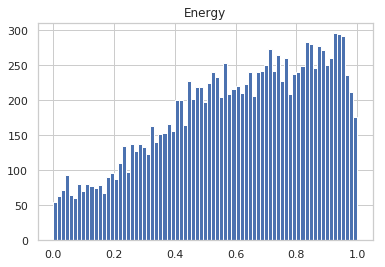

In [15]:
plt.hist(energy_reg_df.Energy,bins = 75)
plt.title('Energy')
plt.savefig('Energy.png')
plt.show()

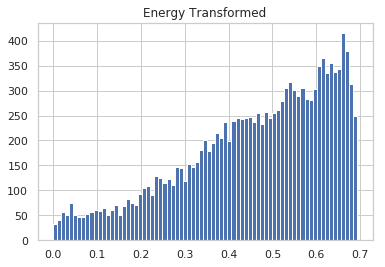

In [16]:
plt.hist(np.log1p(energy_reg_df.Energy),bins = 75)
plt.title('Energy Transformed')
plt.savefig('Energy_transformed.png')
plt.show()

Aside from the target transformation, there are features that became normal or almost normal distribution when transfromed which also helped to improve the model.

In [17]:
#Transforming Features
transformer = PowerTransformer()
energy_reg_df['power_loudness'] = transformer.fit_transform(np.array(energy_reg_df.Loudness).reshape(-1,1))
energy_reg_df['power_Tempo'] = transformer.transform(np.array(energy_reg_df.Tempo).reshape(-1,1))
energy_reg_df['power_Liveness'] = transformer.transform(np.array(energy_reg_df.Liveness).reshape(-1,1))
energy_reg_df['power_Valence'] = transformer.transform(np.array(energy_reg_df.Valence).reshape(-1,1))
energy_reg_df['power_duration'] = transformer.transform(np.array(energy_reg_df.Duration_ms).reshape(-1,1))

In [18]:
# Set dependent and independent variables
##transformed Energy
y = np.log1p(energy_reg_df.Energy)
X = energy_reg_df.drop(['Energy'], axis=1)
# Get dummy variables and add constant for intercept
X = sm.add_constant(X)

# Split data 
np.random.seed(124)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

# fit and summarize your model
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1319.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:46:13   Log-Likelihood:                 16076.
No. Observations:               13773   AIC:                        -3.207e+04
Df Residuals:                   13730   BIC:                        -3.174e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2788      0.007     37.543      0.000       0.264       0.293
Danceability             -0.1245      0.005    -23.728      0.000      -0.135      -0.114
Loudness                  0.0131      0.001     25.509      0.000       0.012       0.014
Speechness                0.1796      0.009     20.098      0.000       0.162       0.197
Acousticness             -0.1890      0.003    -74.366      0.000      -0.194      -0.184
Instrumentalness          0.0456      0.002     20.004      0.000       0.041       0.050
Liveness                  0.0600      0.004     14.606      0.000       0.052       0.068
Valence                   0.1294      0.003     39.420      0.000       0.123       0.136
Tempo                     0.0031      0.000     14.473      0.000       0.003       0.004
Duration_ms            2.866e-08   9.12e-09      3.144      0.002    1.08e-08    4.65e-08
Mode_0                    0.1408      0.004     36.995      0.000       0.133       0.148
Mode_1                    0.1381      0.004     36.791      0.000       0.131       0.145
Super_genre_blues        -0.0056      0.004     -1.329      0.184      -0.014       0.003
Super_genre_classical    -0.0035      0.006     -0.584      0.559      -0.015       0.008
Super_genre_country       0.0057      0.008      0.731      0.465      -0.010       0.021
Super_genre_dance         0.0598      0.007      8.795      0.000       0.046       0.073
Super_genre_disco        -0.0103      0.010     -1.084      0.278      -0.029       0.008
Super_genre_elect         0.0342      0.008      4.549      0.000       0.019       0.049
Super_genre_folk         -0.0259      0.003     -7.531      0.000      -0.033      -0.019
Super_genre_general       0.0111      0.003      4.287      0.000       0.006       0.016
Super_genre_grunge        0.0067      0.011      0.619      0.536      -0.014       0.028
Super_genre_guitar        0.0264      0.004      5.965      0.000       0.018       0.035
Super_genre_hiphop       -0.0322      0.005     -5.978      0.000      -0.043      -0.022
Super_genre_house         0.0132      0.012      1.139      0.255      -0.010       0.036
Super_genre_indie         0.0082      0.004      1.965      0.049    2.19e-05       0.016
Super_genre_jazz          0.0028      0.004      0.719      0.472      -0.005       0.010
Super_genre_latin        -0.0155      0.015     -1.030      0.303      -0.045       0.014
Super_genre_metal         0.0405      0.004     11.415      0.000       0.034       0.047
Super_genre_pop           0.0120      0.003      3.744      0.000       0.006       0.018
Super_genre_punk          0.0254      0.004      5.765      0.000       0.017       0.034
Super_genre_r_and_b      -0.0420      0.023     -1.819      0.069      -0.087       0.003
Super_genre_reggae     

In [19]:
# fit and summarize your model
model = sm.OLS(y_train,X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1058.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:46:13   Log-Likelihood:                 12880.
No. Observations:               11018   AIC:                        -2.567e+04
Df Residuals:                   10975   BIC:                        -2.536e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2828      0.008     34.435      0.000       0.267       0.299
Danceability             -0.1261      0.006    -21.416      0.000      -0.138      -0.115
Loudness                  0.0133      0.001     24.022      0.000       0.012       0.014
Speechness                0.1712      0.010     17.268      0.000       0.152       0.191
Acousticness             -0.1896      0.003    -66.878      0.000      -0.195      -0.184
Instrumentalness          0.0463      0.003     18.197      0.000       0.041       0.051
Liveness                  0.0622      0.005     13.511      0.000       0.053       0.071
Valence                   0.1280      0.004     34.821      0.000       0.121       0.135
Tempo                     0.0031      0.000     12.981      0.000       0.003       0.004
Duration_ms            2.061e-08   9.96e-09      2.069      0.039    1.08e-09    4.01e-08
Mode_0                    0.1430      0.004     33.970      0.000       0.135       0.151
Mode_1                    0.1398      0.004     33.683      0.000       0.132       0.148
Super_genre_blues        -0.0072      0.005     -1.530      0.126      -0.016       0.002
Super_genre_classical    -0.0022      0.007     -0.335      0.737      -0.015       0.011
Super_genre_country       0.0099      0.008      1.183      0.237      -0.007       0.026
Super_genre_dance         0.0621      0.008      8.228      0.000       0.047       0.077
Super_genre_disco        -0.0002      0.011     -0.017      0.986      -0.022       0.021
Super_genre_elect         0.0354      0.008      4.288      0.000       0.019       0.052
Super_genre_folk         -0.0269      0.004     -7.148      0.000      -0.034      -0.020
Super_genre_general       0.0106      0.003      3.768      0.000       0.005       0.016
Super_genre_grunge        0.0011      0.012      0.094      0.925      -0.023       0.025
Super_genre_guitar        0.0241      0.005      4.863      0.000       0.014       0.034
Super_genre_hiphop       -0.0297      0.006     -5.051      0.000      -0.041      -0.018
Super_genre_house         0.0104      0.012      0.837      0.402      -0.014       0.035
Super_genre_indie         0.0071      0.005      1.532      0.125      -0.002       0.016
Super_genre_jazz          0.0021      0.004      0.507      0.612      -0.006       0.010
Super_genre_latin        -0.0144      0.017     -0.831      0.406      -0.048       0.020
Super_genre_metal         0.0396      0.004     10.220      0.000       0.032       0.047
Super_genre_pop           0.0124      0.003      3.555      0.000       0.006       0.019
Super_genre_punk          0.0249      0.005      5.057      0.000       0.015       0.035
Super_genre_r_and_b      -0.0398      0.024     -1.639      0.101      -0.087       0.008
Super_genre_reggae     

In [20]:
# fit and summarize your model
model = sm.OLS(y_test,X_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     267.7
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:46:13   Log-Likelihood:                 3214.4
No. Observations:                2755   AIC:                            -6345.
Df Residuals:                    2713   BIC:                            -6096.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2557      0.018     14.319      0.000       0.221       0.291
Danceability             -0.1190      0.012    -10.199      0.000      -0.142      -0.096
Loudness                  0.0117      0.001      8.412      0.000       0.009       0.014
Speechness                0.2202      0.021     10.547      0.000       0.179       0.261
Acousticness             -0.1862      0.006    -32.081      0.000      -0.198      -0.175
Instrumentalness          0.0429      0.005      8.307      0.000       0.033       0.053
Liveness                  0.0528      0.009      5.743      0.000       0.035       0.071
Valence                   0.1362      0.007     18.484      0.000       0.122       0.151
Tempo                     0.0030      0.000      6.217      0.000       0.002       0.004
Duration_ms            1.185e-07   3.27e-08      3.624      0.000    5.44e-08    1.83e-07
Mode_0                    0.1283      0.009     14.046      0.000       0.110       0.146
Mode_1                    0.1274      0.009     14.151      0.000       0.110       0.145
Super_genre_blues         0.0018      0.009      0.214      0.831      -0.015       0.019
Super_genre_classical    -0.0063      0.014     -0.466      0.641      -0.033       0.020
Super_genre_country      -0.0133      0.020     -0.679      0.497      -0.052       0.025
Super_genre_dance         0.0526      0.015      3.458      0.001       0.023       0.082
Super_genre_disco        -0.0382      0.019     -2.065      0.039      -0.075      -0.002
Super_genre_elect         0.0309      0.018      1.727      0.084      -0.004       0.066
Super_genre_folk         -0.0179      0.008     -2.345      0.019      -0.033      -0.003
Super_genre_general       0.0154      0.005      2.890      0.004       0.005       0.026
Super_genre_grunge        0.0276      0.023      1.224      0.221      -0.017       0.072
Super_genre_guitar        0.0362      0.009      3.895      0.000       0.018       0.054
Super_genre_hiphop       -0.0442      0.013     -3.475      0.001      -0.069      -0.019
Super_genre_house         0.0365      0.033      1.102      0.271      -0.028       0.101
Super_genre_indie         0.0140      0.009      1.534      0.125      -0.004       0.032
Super_genre_jazz          0.0068      0.008      0.814      0.415      -0.010       0.023
Super_genre_latin        -0.0167      0.030     -0.553      0.580      -0.076       0.043
Super_genre_metal         0.0458      0.008      5.775      0.000       0.030       0.061
Super_genre_pop           0.0116      0.007      1.695      0.090      -0.002       0.025
Super_genre_punk          0.0295      0.009      3.174      0.002       0.011       0.048
Super_genre_r_and_b      -0.0666      0.073     -0.911      0.362      -0.210       0.077
Super_genre_reggae     

## Ridge/GridSearch Regression

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
ridge = Ridge(normalize=True)

param = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 10, 10000, 20000]}
rr = GridSearchCV(ridge,param,scoring = 'neg_mean_squared_error',cv=5)
rr.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 10, 10000, 20000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

### Getting best parameters and estimator for Ridge Regression

In [22]:
print("Best alpha: ", rr.best_params_)
print('\n')
print("Best Estimator: ",rr.best_estimator_)
print('\n')
print("Best Score: ",rr.best_score_)

Best alpha:  {'alpha': 1e-15}


Best Estimator:  Ridge(alpha=1e-15, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)


Best Score:  -0.005737349259761643


## Reiterating Ridge Regression

In [23]:
ridge2 = Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))
print(ridge2.score(X_train,y_train))

const                    0.000000e+00
Danceability            -1.256030e-01
Loudness                 1.326419e-02
Speechness               1.707351e-01
Acousticness            -1.895948e-01
Instrumentalness         4.634469e-02
Liveness                 6.228622e-02
Valence                  1.279527e-01
Tempo                    3.087139e-03
Duration_ms              2.069177e-08
Mode_0                   1.574006e-03
Mode_1                  -1.574006e-03
Super_genre_blues       -1.425149e-02
Super_genre_classical   -9.280270e-03
Super_genre_country      2.850622e-03
Super_genre_dance        5.505770e-02
Super_genre_disco       -7.234799e-03
Super_genre_elect        2.832715e-02
Super_genre_folk        -3.388815e-02
Super_genre_general      3.562826e-03
Super_genre_grunge      -5.898586e-03
Super_genre_guitar       1.704313e-02
Super_genre_hiphop      -3.689410e-02
Super_genre_house        3.299268e-03
Super_genre_indie        6.338420e-05
Super_genre_jazz        -4.913384e-03
Super_genre_

## Variable Selection work

the code below will step through adding variables to our regression and provide the r squared and adjusted r squared scores along the way.  

_Note: depending on the number of variables, this will take a while to run._

In [24]:
# predictors = X

# linreg = LinearRegression()
# for i in range(1,X.shape[1]):
#     print("\n\n")
#     print('Num Variables', i)
#     selector = RFE(linreg, n_features_to_select=i)

#     selector = selector.fit(X=predictors, y=y)

#     print("Which columns were kept:\t", selector.support_)
# #     print("The coefficients:\t\t", selector.estimator_.coef_)
# #     print("The intercept:\t\t\t", selector.estimator_.intercept_)
#     r_squared = selector.score(predictors,y)
#     adj_r_squared = adjusted_r_squared(r_squared, X.shape[0], i)

    
#     print("R Squared\t\t", r_squared)
#     print("Adjusted R Squared\t", adj_r_squared)